In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
import geopy.distance as geo
from haversine import haversine
from sklearn.preprocessing import StandardScaler, Normalizer

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
%%time
data = dd.read_csv('train.csv')
data = data.sample(frac=0.01).compute()

CPU times: user 1min 52s, sys: 8.55 s, total: 2min 1s
Wall time: 2min 13s


In [7]:
type(data)

pandas.core.frame.DataFrame

## PREPROCESSING

In [58]:
train = dd.from_pandas(data, npartitions = 16)

In [59]:
type(train)

dask.dataframe.core.DataFrame

In [60]:
%%time 
train.head(n=10)

CPU times: user 2.13 ms, sys: 197 µs, total: 2.33 ms
Wall time: 2.09 ms


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2013-09-26 20:31:00.000000210,8.0,2013-09-26 20:31:00 UTC,-73.975782,40.745062,-73.991407,40.756060,5
0,2012-02-29 14:35:55.0000003,8.1,2012-02-29 14:35:55 UTC,-73.986216,40.734511,-73.968246,40.759619,3
5,2014-07-16 11:02:00.00000094,15.0,2014-07-16 11:02:00 UTC,-73.962988,40.769505,-73.968017,40.802332,1
5,2010-05-08 01:15:00.000000243,7.7,2010-05-08 01:15:00 UTC,-73.965733,40.692628,-73.961562,40.716297,5
6,2015-01-31 17:41:53.0000001,7.5,2015-01-31 17:41:53 UTC,-73.974045,40.783836,-73.980278,40.764935,1
6,2014-07-01 23:52:00.00000018,7.5,2014-07-01 23:52:00 UTC,-73.985010,40.747510,-73.978440,40.764740,6
7,2009-11-21 15:52:33.0000001,8.9,2009-11-21 15:52:33 UTC,-73.979428,40.747161,-73.980598,40.770765,1
10,2013-09-14 09:56:00.000000114,6.5,2013-09-14 09:56:00 UTC,-73.990082,40.749947,-74.000417,40.757660,1
14,2009-08-10 09:06:46.0000003,4.5,2009-08-10 09:06:46 UTC,-73.966676,40.757271,-73.973790,40.759743,1
16,2011-03-23 20:47:24.0000001,10.5,2011-03-23 20:47:24 UTC,-73.984044,40.758590,-74.000518,40.720898,1


In [61]:
%%time
data.head(n=10)

CPU times: user 606 µs, sys: 56 µs, total: 662 µs
Wall time: 642 µs


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
605798,2014-01-13 10:37:44.0000005,8.00,2014-01-13 10:37:44 UTC,-73.970052,40.763596,-73.987623,40.752304,1
352767,2011-05-12 18:07:00.00000053,8.90,2011-05-12 18:07:00 UTC,-73.967120,40.788462,-73.960023,40.771202,2
98378,2009-07-22 18:07:00.000000193,6.90,2009-07-22 18:07:00 UTC,-74.002837,40.747117,-73.997948,40.734493,1
138992,2009-06-13 01:03:00.000000226,9.30,2009-06-13 01:03:00 UTC,-73.986683,40.729882,-73.972283,40.754483,1
111422,2010-08-01 07:04:00.00000033,49.57,2010-08-01 07:04:00 UTC,-73.785755,40.639600,-73.978192,40.748370,1
586768,2011-06-12 18:07:00.000000123,9.70,2011-06-12 18:07:00 UTC,-73.991258,40.724013,-73.987867,40.745613,1
160857,2014-03-22 20:42:46.0000002,20.00,2014-03-22 20:42:46 UTC,-73.986715,40.733174,-73.978355,40.791506,2
285706,2011-07-25 14:51:57.0000003,10.10,2011-07-25 14:51:57 UTC,-73.992280,40.738098,-74.000326,40.719902,1
90915,2013-05-03 21:05:00.000000159,4.00,2013-05-03 21:05:00 UTC,-73.978897,40.748135,-73.981825,40.741020,2
449789,2014-11-14 22:35:00.00000069,13.50,2014-11-14 22:35:00 UTC,-73.992972,40.768222,-73.953757,40.800465,1


fare_amount is our target variable. This is a regression problem.

In [62]:
train.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 8 entries, key to passenger_count
dtypes: object(2), float64(5), int64(1)

In [63]:
%time data.isna().any()

CPU times: user 213 ms, sys: 0 ns, total: 213 ms
Wall time: 211 ms


key                  False
fare_amount          False
pickup_datetime      False
pickup_longitude     False
pickup_latitude      False
dropoff_longitude     True
dropoff_latitude      True
passenger_count      False
dtype: bool

In [64]:
%time train.isna().any().compute()

CPU times: user 338 ms, sys: 14.8 ms, total: 353 ms
Wall time: 339 ms


key                  False
fare_amount          False
pickup_datetime      False
pickup_longitude     False
pickup_latitude      False
dropoff_longitude     True
dropoff_latitude      True
passenger_count      False
dtype: bool

There are missing values in dropoff_latitude and dropoff_longitude columns.

In [65]:
%%time
print(train['dropoff_latitude'].isna().sum().compute(),
train['dropoff_longitude'].isna().sum().compute())

9 9
CPU times: user 40.8 ms, sys: 4.86 ms, total: 45.7 ms
Wall time: 43.6 ms


In [66]:
%%time
print(data['dropoff_latitude'].isna().sum(),
data['dropoff_longitude'].isna().sum())

9 9
CPU times: user 0 ns, sys: 4.24 ms, total: 4.24 ms
Wall time: 3.46 ms


Only 4 missing values in both columns out of 55 lakh values.

In [67]:
%time train['dropoff_latitude'].value_counts().compute()

CPU times: user 444 ms, sys: 4.76 ms, total: 449 ms
Wall time: 320 ms


 0.000000      10492
 41.366138       148
 40.750415        37
 40.750300        35
 40.750097        34
               ...  
 40.772801         1
 40.772791         1
 40.772781         1
 40.772764         1
-180.000000        1
Name: dropoff_latitude, Length: 140524, dtype: int64

In [68]:
%time data['dropoff_latitude'].value_counts()

CPU times: user 65.3 ms, sys: 0 ns, total: 65.3 ms
Wall time: 65.8 ms


0.000000     10492
41.366138      148
40.750415       37
40.750300       35
40.750097       34
             ...  
40.690928        1
40.646347        1
40.790890        1
40.839560        1
40.695053        1
Name: dropoff_latitude, Length: 140524, dtype: int64

In [69]:
train['dropoff_longitude'].value_counts().compute()

 0.000000       10528
-73.137393        148
-73.988900         44
-73.991300         44
-73.982400         43
                ...  
-73.929068          1
-73.929070          1
-73.929072          1
-73.929073          1
-2241.062283        1
Name: dropoff_longitude, Length: 111402, dtype: int64

In both of the columns above, 0 is the mode. Let's replace the missing values with mode.

In [70]:
train['dropoff_latitude'] = train['dropoff_latitude'].fillna(train['dropoff_latitude'].mean().compute())
train['dropoff_longitude'] = train['dropoff_longitude'].fillna(train['dropoff_longitude'].mean().compute())

In [71]:
train.isna().sum().compute()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

Now, there are no missing values. Let's see the distributions of all the numerical columns in the dataset.

In [72]:
num_cols = train.select_dtypes(include=np.number).columns
print(num_cols)

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')


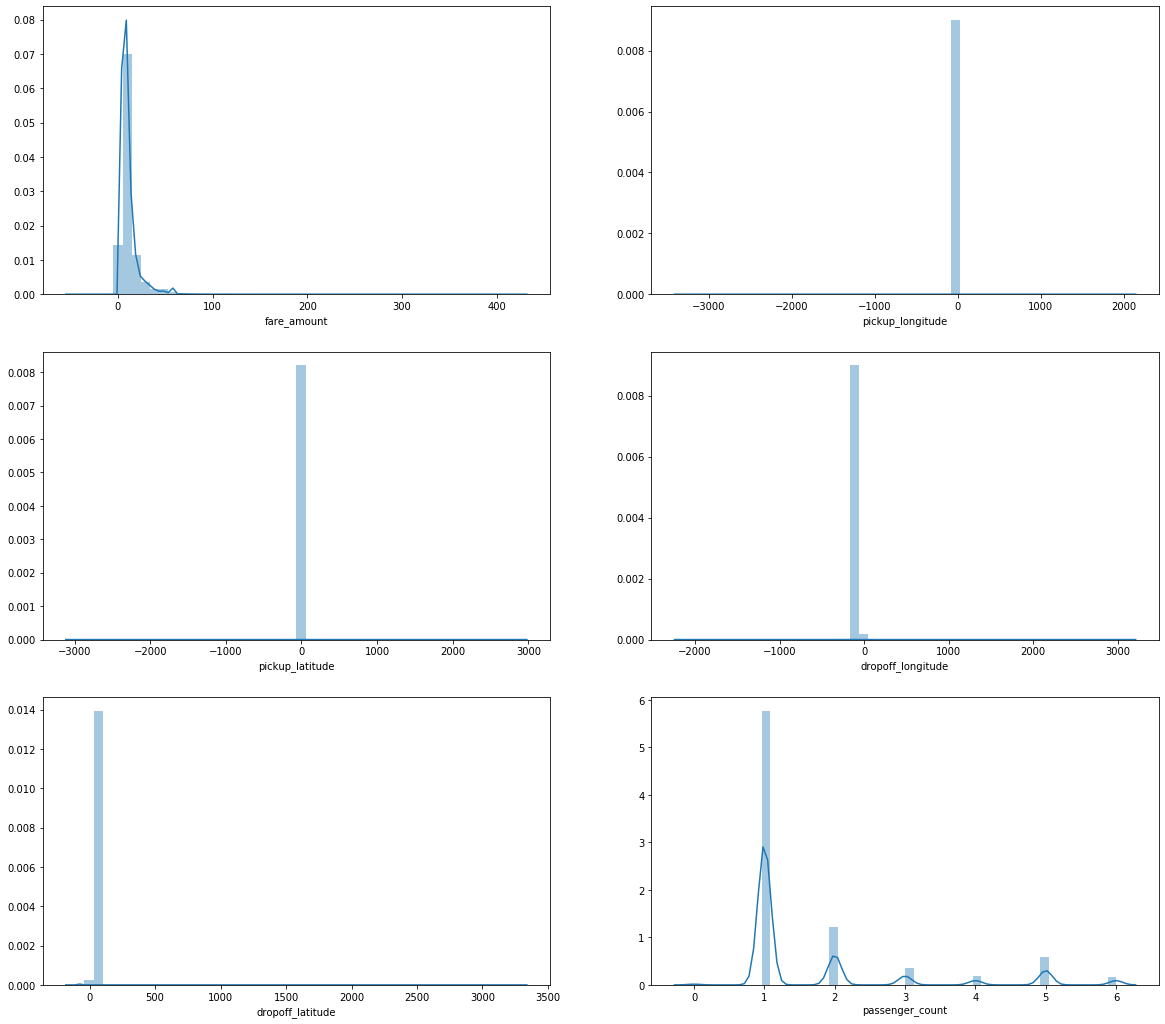

In [73]:
fig,ax = plt.subplots(3,2,figsize=(20,18))
ax = ax.flatten()

for k,i in enumerate(num_cols):
    sns.distplot(train[i], ax=ax[k])

## FEATURE ENGINEERING

In [74]:
train.head(n=10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2013-09-26 20:31:00.000000210,8.0,2013-09-26 20:31:00 UTC,-73.975782,40.745062,-73.991407,40.756060,5
0,2012-02-29 14:35:55.0000003,8.1,2012-02-29 14:35:55 UTC,-73.986216,40.734511,-73.968246,40.759619,3
5,2014-07-16 11:02:00.00000094,15.0,2014-07-16 11:02:00 UTC,-73.962988,40.769505,-73.968017,40.802332,1
5,2010-05-08 01:15:00.000000243,7.7,2010-05-08 01:15:00 UTC,-73.965733,40.692628,-73.961562,40.716297,5
6,2015-01-31 17:41:53.0000001,7.5,2015-01-31 17:41:53 UTC,-73.974045,40.783836,-73.980278,40.764935,1
6,2014-07-01 23:52:00.00000018,7.5,2014-07-01 23:52:00 UTC,-73.985010,40.747510,-73.978440,40.764740,6
7,2009-11-21 15:52:33.0000001,8.9,2009-11-21 15:52:33 UTC,-73.979428,40.747161,-73.980598,40.770765,1
10,2013-09-14 09:56:00.000000114,6.5,2013-09-14 09:56:00 UTC,-73.990082,40.749947,-74.000417,40.757660,1
14,2009-08-10 09:06:46.0000003,4.5,2009-08-10 09:06:46 UTC,-73.966676,40.757271,-73.973790,40.759743,1
16,2011-03-23 20:47:24.0000001,10.5,2011-03-23 20:47:24 UTC,-73.984044,40.758590,-74.000518,40.720898,1


One feature we can create is the distance(in km) between the given geographical points.

In [75]:
train['hdist'] = train.apply(lambda x: haversine((x['pickup_latitude'], x['pickup_longitude']), (x['dropoff_latitude'], x['dropoff_longitude'])), axis = 1)

/home/mendax/.local/lib/python3.6/site-packages/dask/dataframe/core.py:4083: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))


In [76]:
train.head(n=10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hdist
0,2013-09-26 20:31:00.000000210,8.0,2013-09-26 20:31:00 UTC,-73.975782,40.745062,-73.991407,40.756060,5,1.796642
0,2012-02-29 14:35:55.0000003,8.1,2012-02-29 14:35:55 UTC,-73.986216,40.734511,-73.968246,40.759619,3,3.175888
5,2014-07-16 11:02:00.00000094,15.0,2014-07-16 11:02:00 UTC,-73.962988,40.769505,-73.968017,40.802332,1,3.674675
5,2010-05-08 01:15:00.000000243,7.7,2010-05-08 01:15:00 UTC,-73.965733,40.692628,-73.961562,40.716297,5,2.655257
6,2015-01-31 17:41:53.0000001,7.5,2015-01-31 17:41:53 UTC,-73.974045,40.783836,-73.980278,40.764935,1,2.166337
6,2014-07-01 23:52:00.00000018,7.5,2014-07-01 23:52:00 UTC,-73.985010,40.747510,-73.978440,40.764740,6,1.994211
7,2009-11-21 15:52:33.0000001,8.9,2009-11-21 15:52:33 UTC,-73.979428,40.747161,-73.980598,40.770765,1,2.626498
10,2013-09-14 09:56:00.000000114,6.5,2013-09-14 09:56:00 UTC,-73.990082,40.749947,-74.000417,40.757660,1,1.222051
14,2009-08-10 09:06:46.0000003,4.5,2009-08-10 09:06:46 UTC,-73.966676,40.757271,-73.973790,40.759743,1,0.659229
16,2011-03-23 20:47:24.0000001,10.5,2011-03-23 20:47:24 UTC,-73.984044,40.758590,-74.000518,40.720898,1,4.415003


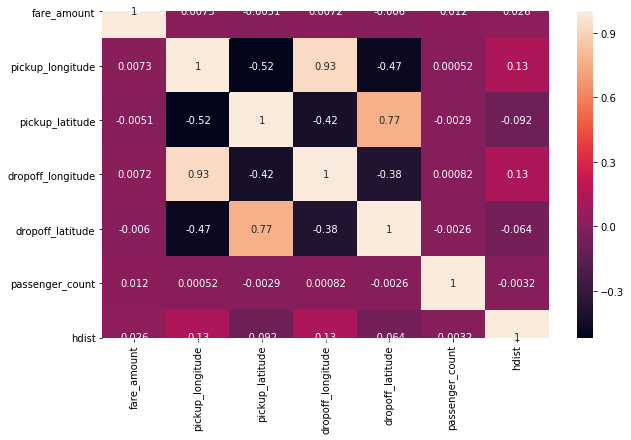

In [77]:
plt.figure(figsize=(10,6))
sns.heatmap(train.corr().compute(), annot=True)

No features are correlated with the target variables. Latitudes and Longitudes are correlated to each other.

In [78]:
train['pickup_datetime'] = dd.to_datetime(train['pickup_datetime'])

In [79]:
train['pickup_month'] = train['pickup_datetime'].apply(lambda x : x.month)
train['pickup_day'] = train['pickup_datetime'].apply(lambda x : x.day)
train['pickup_hour'] = train['pickup_datetime'].apply(lambda x : x.hour)
train['isweekend'] = train['pickup_datetime'].apply(lambda x : 1 if x.weekday_name in ['Sunday', 'Saturday'] else 0)

/home/mendax/.local/lib/python3.6/site-packages/dask/dataframe/core.py:3020: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('pickup_datetime', 'int64'))

  warnings.warn(meta_warning(meta))
/home/mendax/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  after removing the cwd from sys.path.


In [80]:
train.head(n=10)

/home/mendax/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  after removing the cwd from sys.path.


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hdist,pickup_month,pickup_day,pickup_hour,isweekend
0,2013-09-26 20:31:00.000000210,8.0,2013-09-26 20:31:00+00:00,-73.975782,40.745062,-73.991407,40.756060,5,1.796642,9,26,20,0
0,2012-02-29 14:35:55.0000003,8.1,2012-02-29 14:35:55+00:00,-73.986216,40.734511,-73.968246,40.759619,3,3.175888,2,29,14,0
5,2014-07-16 11:02:00.00000094,15.0,2014-07-16 11:02:00+00:00,-73.962988,40.769505,-73.968017,40.802332,1,3.674675,7,16,11,0
5,2010-05-08 01:15:00.000000243,7.7,2010-05-08 01:15:00+00:00,-73.965733,40.692628,-73.961562,40.716297,5,2.655257,5,8,1,1
6,2015-01-31 17:41:53.0000001,7.5,2015-01-31 17:41:53+00:00,-73.974045,40.783836,-73.980278,40.764935,1,2.166337,1,31,17,1
6,2014-07-01 23:52:00.00000018,7.5,2014-07-01 23:52:00+00:00,-73.985010,40.747510,-73.978440,40.764740,6,1.994211,7,1,23,0
7,2009-11-21 15:52:33.0000001,8.9,2009-11-21 15:52:33+00:00,-73.979428,40.747161,-73.980598,40.770765,1,2.626498,11,21,15,1
10,2013-09-14 09:56:00.000000114,6.5,2013-09-14 09:56:00+00:00,-73.990082,40.749947,-74.000417,40.757660,1,1.222051,9,14,9,1
14,2009-08-10 09:06:46.0000003,4.5,2009-08-10 09:06:46+00:00,-73.966676,40.757271,-73.973790,40.759743,1,0.659229,8,10,9,0
16,2011-03-23 20:47:24.0000001,10.5,2011-03-23 20:47:24+00:00,-73.984044,40.758590,-74.000518,40.720898,1,4.415003,3,23,20,0


/home/mendax/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  after removing the cwd from sys.path.
/home/mendax/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  after removing the cwd from sys.path.
/home/mendax/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  after removing the cwd from sys.path.
/home/mendax/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  after removing the cwd from sys.path.
/home/mendax/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `weekday_name` is deprecated

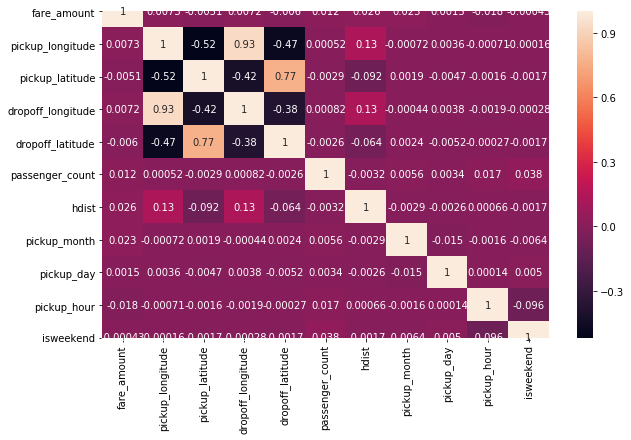

In [81]:
plt.figure(figsize=(10,6))
sns.heatmap(train.corr().compute(), annot=True)

In [ ]:
%time train.corr().compute()

/home/mendax/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  after removing the cwd from sys.path.
/home/mendax/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  after removing the cwd from sys.path.
/home/mendax/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  after removing the cwd from sys.path.


In [ ]:
%time data.corr()

In [ ]:
## NOW PERSIST THE DASK DATAFRAME TO MEMORY.

In [ ]:
train.persist()

In [ ]:
%time train.corr().compute()